In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    sys.path.append(path)

%load_ext autoreload
%autoreload 2

In [3]:
alg = [0]
diff = [1]
n_var = len(alg) + len(diff)

dep_mat = np.zeros(( n_var, n_var ))
for j in [[0,1], [1,1]]:
    dep_mat[j[0], j[1]] = 1.
    
dep_mat_delay = np.zeros(( n_var, n_var ))

offset_mat = [0., 1., 0.]
fs_ = 16.

def plot(time, state, target, u):
    fig, ax = plt.subplots(n_var+1,1, figsize=(10,12))
    for j in range(n_var):
        ax[j].plot(time, state[j,:])
    ax[0].plot(time, target[:], color='grey', linestyle='--')
    ax[-1].plot(time, u[:], color='red', label='control')
    
    plt.show()
    
def time_integration(x0, T, u, dt):
    time_steps_total = x0.shape[1] + np.around(T/dt, 0).astype(int)
        
    x = np.zeros(( n_var, time_steps_total ))
    x[:,:x0.shape[1]] = x0[:,:]
    
    #if x0.shape[1] != delay+1:
    #    print("WARNING: initial state does not have correct length")
        
    for t in range(x0.shape[1], time_steps_total, 1):
        mu_dt = ( mu_ext - x[1,t-1] + u[t-1-delay]) / tau
        x[1,t] = x[1,t-1] + dt * mu_dt
        x[0,t] = r_func(x[1,t])        
    
    return x

In [4]:
delay = 0
x0 = np.ones(( n_var,max(delay+1,1) ))

tau = 10.
mu_ext = 1.

x_shift = - .2
x_scale = 0.05
y_shift = 100.
y_scale = 10.

def r_func(mu):
    return y_shift + np.tanh(x_scale * mu + x_shift) * y_scale
    #return mu

def r_der(mu):
    #return 1.
    return x_scale * y_scale / np.cosh(x_scale * mu + x_shift)**2
    
T = 200.
dt = 0.1
    
time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
u0[1980] = 10.
x = time_integration(x0, T, u0, dt)
x0[:,:] = x[:,-delay-1:]
print(x0)

[[98.55156705]
 [ 1.08261686]]


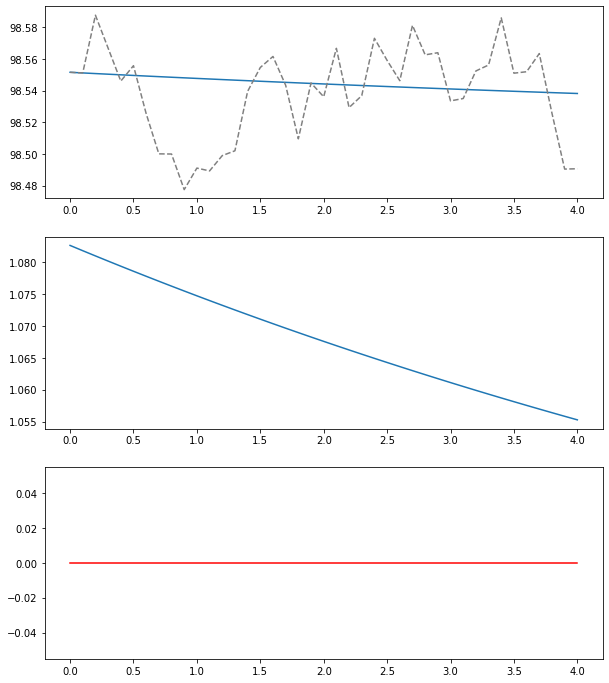

j, t unknown 0 0 2
j, t unknown 1 0 2
0.00019183529275729194
j, t unknown 0 1 2
j, t unknown 1 1 2
8.759113846734667e-06
j, t unknown 0 2 2
j, t unknown 1 2 2
8.673818821525181e-06
j, t unknown 0 3 2
j, t unknown 1 3 2
8.589328625518977e-06
j, t unknown 0 4 2
j, t unknown 1 4 2
8.50563674986704e-06
j, t unknown 0 5 2
j, t unknown 1 5 2
8.422766940630044e-06
j, t unknown 0 6 2
j, t unknown 1 6 2
8.340631230840945e-06
j, t unknown 0 7 2
j, t unknown 1 7 2
8.259315947889423e-06
j, t unknown 0 8 2
j, t unknown 1 8 2
8.1787633462449e-06
j, t unknown 0 9 2
j, t unknown 1 9 2
8.098968467151746e-06
j, t unknown 0 10 2
j, t unknown 1 10 2
8.019945825110675e-06
j, t unknown 0 11 2
j, t unknown 1 11 2
7.941660775612203e-06
j, t unknown 0 12 2
j, t unknown 1 12 2
7.864114129618738e-06
j, t unknown 0 13 2
j, t unknown 1 13 2
7.787330108199875e-06
j, t unknown 0 14 2
j, t unknown 1 14 2
7.711250491038157e-06
j, t unknown 0 15 2
j, t unknown 1 15 2
7.635914535897292e-06
j, t unknown 0 16 2
j, t unkno

In [13]:
T = 4.
time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
x = time_integration(x0, T, u0, dt)
state = x.copy()

u = np.zeros(time.shape[0])
for t in np.arange(1,len(time)-2,1):
    u[t] = random.uniform(-8.,8.)
#u[1] = 2.
x = time_integration(x0, T, u, dt)
target = np.zeros((time.shape[0]))
target[:] = x[0,delay:]

plot(time, state[:,delay:], target[:], u0)

for t in range(40):
    jac_0, jac_delay_0 = jacobian(state, t, 0, True, delay)
    jac_1, jac_delay_1 = jacobian(state, t, 3, True, delay)

    #print(jac_0)
    #print(jac_delay_0)
    #print(jac_1)
    #print(jac_delay_1)
    
    print(np.amax(np.abs(jac_0-jac_1)))

In [19]:
weight = 0.
it = 100
step0 = 1000.

label_ = ['M0 : analytic adjoint']
print(label_[-1])
method = 0
u_0, c_0 = iterate(it, state, target, weight, u0, x0, T, method, step0, False, False)
#x = time_integration(x0, T, u_0, dt)
#plot(time, x[:,delay:], target, u_0)
c_array = [c_0]

#plt.plot(time, u_0-u)
#plt.show()

if True:
    label_.append('M1 : distinguish constant offset, include delay terms')
    print(label_[-1])
    method = 3
    offset = True
    delay_ = True
    u_1, c_1 = iterate(it, state, target, weight, u0, x0, T, method, step0, offset, delay_)
    #x = time_integration(x0, T, u_1, dt)
    #plot(time, x[:,delay:], target, u_1)
    c_array.append(c_1)

if True:
    label_.append('M2 : all variables constant offset, include delay terms')
    print(label_[-1])
    method = 3
    offset = False
    delay_ = True
    u_2, c_2 = iterate(it, state, target, weight, u0, x0, T, method, step0, offset, delay_)
    c_array.append(c_2)

if True:
    label_.append('M3 : all variables constant offset, ignore delay terms')
    print(label_[-1])
    method = 3
    offset = False
    delay_ = False
    u_3, c_3 = iterate(it, state, target, weight, u0, x0, T, method, step0, offset, delay_)
    c_array.append(c_3)

if True:
    label_.append('M4 : distinguish constant offset, ignore delay terms')
    print(label_[-1])
    method = 3
    offset = True
    delay_ = False
    u_4, c_4 = iterate(it, state, target, weight, u0, x0, T, method, step0, offset, delay_)
    c_array.append(c_4)
    

M0 : analytic adjoint
Initial cost =  2.271653013659273
1  cost =  0.1965322338857154
2  cost =  0.09473166620440412
3  cost =  0.07428989840808406
4  cost =  0.06087706587139646
5  cost =  0.05189756000856227
6  cost =  0.044856642811912865
7  cost =  0.03983798809215921
8  cost =  0.03594677706850287
9  cost =  0.03301145990265977
10  cost =  0.0304403545159968
50  cost =  0.012752127630379006
100  cost =  0.009490192520496809
M1 : distinguish constant offset, include delay terms
Initial cost =  2.271653013659273
1  cost =  0.19653148890950747
2  cost =  0.09478727920921283
3  cost =  0.0742946236846565
4  cost =  0.060899142071853034
5  cost =  0.05190127330507465
6  cost =  0.04487139635575288
7  cost =  0.039838770175231596
8  cost =  0.03591338287776593
9  cost =  0.03301216918195472
10  cost =  0.030404461327948513
50  cost =  0.009463365941539799
100  cost =  0.007806802190895874
M2 : all variables constant offset, include delay terms
Initial cost =  2.271653013659273
1  cost =

M0 : analytic adjoint 0.011812725291168048
M1 : distinguish constant offset, include delay terms 0.011885295398022312
M2 : all variables constant offset, include delay terms 0.06354740401653083
M3 : all variables constant offset, ignore delay terms 0.011937384393373444
M4 : distinguish constant offset, ignore delay terms 0.011937384393373444


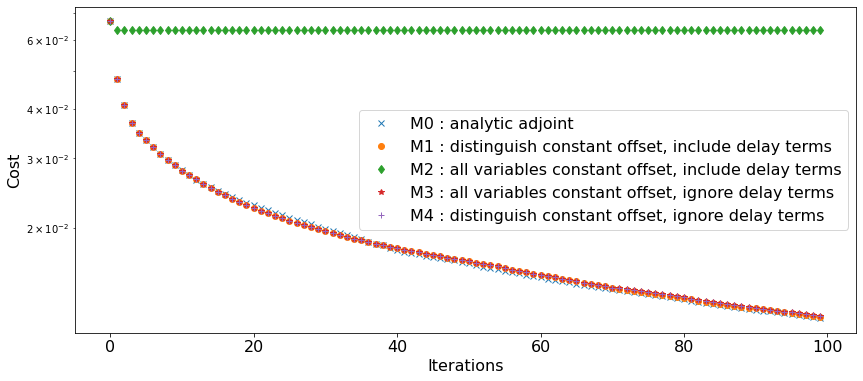

In [15]:
markerlist = ['x', 'o', 'd', '*', '+']
markersizelist = [6]*10

fig, ax = plt.subplots(1, figsize=(14,6))
for i in range(len(label_)):
    c_ = c_array[i][1:]
    ax.plot(np.arange(0,len(c_),1), c_, linestyle='', marker=markerlist[i], markersize=markersizelist[i],
            label=label_[i])
    print(label_[i], c_[-1])
ax.legend(fontsize=fs_)
ax.set_ylabel('Cost', fontsize=fs_)
ax.set_xlabel('Iterations', fontsize=fs_)
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=fs_)
ax.tick_params(axis='y', labelsize=fs_)
plt.show()

In [6]:
def adjoint(st_, fp, method, offset, delay_):
    adjoint = np.zeros((st_[:,delay:].shape))
    
    t = adjoint.shape[1]-1
    jac_t0, jac_delay_t0 = jacobian(st_, t, method, offset, delay_)
    
    #print(jac_t0)
    #print(jac_delay_t0)
            
    adjoint[0,t] = fp[t]
    adjoint[1,t] = dt * ( adjoint[0,t] * jac_t0[0,1] )
    #adjoint[2,t] = dt * ( adjoint[1,t] * jac_t0[1,2] )
    
    for t in range(adjoint.shape[1]-2, -1, -1):
        jac_t1, jac_delay_t1 = jacobian(st_, t+1, method, offset, delay_)
        jac_t0, jac_delay_t0 = jacobian(st_, t, method, offset, delay_)
        
        #print(t)
                
        for k in alg:
            adjoint[k,t] = fp[t]
            for k1 in range(n_var):
                adjoint[k,t] += adjoint[k1,t+1] * jac_t1[k1,k]
                if t+1+delay < adjoint.shape[1]:
                    #print("delay", k, k1, adjoint[k1,t+1+delay], jac_delay_t1[k1,k])
                    adjoint[k,t] += adjoint[k1,t+1+delay] * jac_delay_t1[k1,k]
        for k in diff:
            der = 0.
            for k1 in range(n_var):
                #if t == 5 and k == 2:
                #    print(k, k1, adjoint[k1,t], jac_t0[k1,k])
                #    print(k, k1, adjoint[k1,t+1], jac_t1[k1,k])
                if k1 in alg:
                    der += adjoint[k1,t] * jac_t0[k1,k]
                elif k1 in diff:
                    der += adjoint[k1,t+1] * jac_t1[k1,k]
                    #if [k,k1] == [2,2]: print(adjoint[k1,t+1] , jac_t1[k1,k])
                #if t+1+delay < adjoint.shape[1]:
                #    der += adjoint[k1,t+1+delay] * jac_delay_t1[k1,k]
            adjoint[k,t] = adjoint[k,t+1] + dt * der
            
    #print(adjoint[2,:])
                    
    return adjoint

In [14]:
def jacobian_3(st_, t, offset, delay_):
    jacobian = np.zeros(( st_.shape[0], st_.shape[0] ))
    jacobian_delay = np.zeros(( st_.shape[0], st_.shape[0] ))
    
    #print(t, t-delay)
    
    n_unknown = n_var + 1
    limit_ = 1e-10
    T_end = ( n_unknown + 1 ) * dt
    u0 = np.zeros(n_unknown+1)
    if True:
        x0 = np.zeros((n_var,max(delay+1,1) ))
        for t_ in range(x0.shape[1]):
            x0[:,t_] = st_[:,t+t_]
    else:
        x0 = np.zeros((n_var,1 ))
        x0[:,0] = st_[:,t+delay]
    
    state1 = time_integration(x0, T_end, u0, dt)
    
    #if t == 5:
    #    print(x0)
    #    print(state1)
    
    for t_ in range(x0.shape[1]):
        x0[:,t_] = st_[:,max(0,t-delay+t_)]
    st_del = time_integration(x0, T_end, u0, dt)
    
    if offset:
        offs_ = offset_mat.copy()
    else:
        offs_ = np.ones((n_var))
        
    if delay_:
        m_delay = dep_mat_delay.copy()
    else:
        m_delay = np.zeros((n_var, n_var))
    
    for j in range(n_var):
        
        n_unknown = int(sum(dep_mat[j,:]) + sum(dep_mat_delay[j,:]) + offs_[j])
            
        if n_unknown == 1:
            offs_[j] = 1.
            n_unknown += 1

        A_ = np.zeros(( n_unknown, n_unknown ))
        x_ = np.zeros(( n_unknown ))
        
        if j in alg:
            
            for t_ in range(n_unknown):
                ind_mat = 0
                for k in range(int(sum(dep_mat[j,:]))):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t_,k] = state1[ind_mat,t_+delay]
                    ind_mat += 1
                ind_mat = 0
                for k in np.arange(int(sum(dep_mat[j,:])), int(sum(dep_mat[j,:])+sum(dep_mat_delay[j,:])), 1):
                    #print("delay")
                    while dep_mat_delay[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t_,k] = st_del[ind_mat,t_+delay]
                    ind_mat += 1
                if offs_[j] == 1.:
                    A_[t_,-1] = 1.
                x_[t_] = state1[j,t_+delay]
                        
        elif j in diff:      
         
            for t_ in range(n_unknown):
                ind_mat = 0
                for k in range(int(sum(dep_mat[j,:]))):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t_,k] = state1[ind_mat,t_+delay]
                    ind_mat += 1
                ind_mat = 0
                for k in np.arange(int(sum(dep_mat[j,:])), int(sum(dep_mat[j,:])+sum(dep_mat_delay[j,:])), 1):
                    print("delay")
                    while dep_mat_delay[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t_,k] = st_del[ind_mat,t_+delay]
                    ind_mat += 1
                if offs_[j] == 1.:
                    A_[t_,-1] = 1.
                x_[t_] = ( state1[j,t_+delay+1] - state1[j,t_+delay] ) / dt
                
        #print('j, t unknown', j, t, n_unknown)
        #if j == 2:
        #    print('0 ', st_[0,:])
        #    print('2 : ', st_[2,:])
        #    print('A_ = ', A_)
        #    print('x_ ', x_)

        if np.amax(x_) - np.amin(x_) < limit_:
            jacobian[j,:] = 0.
        else:
            sol = np.linalg.solve(A_, x_)
            ind_mat = 0
            for k in range(int(sum(dep_mat[j,:]))):
                while dep_mat[j,ind_mat] == 0.:
                    ind_mat += 1
                jacobian[j,ind_mat] = sol[k]
                ind_mat += 1
            ind_mat = 0
            for k in np.arange(int(sum(dep_mat[j,:])), int(sum(dep_mat[j,:])+sum(dep_mat_delay[j,:])), 1):
                while dep_mat_delay[j,ind_mat] == 0.:
                    ind_mat += 1
                jacobian_delay[j,ind_mat] = sol[k]
                ind_mat += 1
                    
            #print('j, sol', j, sol)
    
    return jacobian, jacobian_delay

In [11]:
def jacobian(st_, t, method, offset, delay_):
    if method == 0:
        return jacobian_0(st_, t)
    elif method == 2:
        return jacobian_2(st_, t)
    elif method == 3:
        return jacobian_3(st_, t, offset, delay_)

def jacobian_0(state_, t):
    st_ = state_[:,t+delay-1]
    st_del = state_[:,t]
    jacobian = np.zeros(( st_.shape[0], st_.shape[0] ))
    jacobian_delay = np.zeros(( st_.shape[0], st_.shape[0] ))
    
    jacobian[0,1] = r_der(st_[1])
    jacobian[1,1] = -1./tau
    return jacobian, jacobian_delay

def jacobian_2(st_, t):
    jacobian = np.zeros(( st_.shape[0], st_.shape[0] ))
    jacobian_delay = np.zeros(( st_.shape[0], st_.shape[0] ))
    
    n_unknown = n_var + 1
    limit_ = 1e-10
    T_end = ( n_unknown + 1 ) * dt
    u0 = np.zeros(n_unknown+1)
    x0 = np.zeros((n_var,max(delay+1,1) ))
    #for t_ in range(x0.shape[1]):
    #    x0[:,t_] = st_[:,t]
    #x0[:,:] = st_[:,max(0,t-2):t+delay-1]
    state1 = time_integration(x0, T_end, u0, dt)
    
    if offset == True:
        offs_ = offset_mat.copy()
    else:
        offs_ = np.zeros((n_var))
    
    for j in range(n_var):
        if j in alg:
            n_unknown = int(sum(dep_mat[j,:]) + 1)
            A_ = np.zeros(( n_unknown, n_unknown ))
            x_ = np.zeros(( n_unknown ))
            
            for t in range(n_unknown):
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t,k] = state1[ind_mat,t]
                    ind_mat += 1
                A_[t,-1] = 1.
                x_[t] = state1[j,t]

            if np.amax(x_) - np.amin(x_) < limit_:
                jacobian[j,:] = 0.
            else:
                sol = np.linalg.solve(A_, x_)
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    jacobian[j,ind_mat] = sol[k]
                    ind_mat += 1
        
        elif j in diff:
            n_unknown = int(sum(dep_mat[j,:]) + 1)
            A_ = np.zeros(( n_unknown, n_unknown ))
            x_ = np.zeros(( n_unknown ))
            
            for t in range(n_unknown):
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t,k] = state1[ind_mat,t]
                    ind_mat += 1
                A_[t,-1] = 1.
                x_[t] = ( state1[j,t+1] - state1[j,t] ) / dt

            if np.amax(x_) - np.amin(x_) < limit_:
                jacobian[j,:] = 0.
            else:
                sol = np.linalg.solve(A_, x_)
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    jacobian[j,ind_mat] = sol[k]
                    ind_mat += 1
    
    return jacobian, jacobian_delay

In [9]:
def fp(state, target):
    return (state[0,delay:] - target[:])

def fu(w, u):
    return w*u
    
def grad(adjoint, fu):
    grad = np.zeros((adjoint.shape[1]))
    for t in range(grad.shape[0]-1):
        grad[t] = fu[t] + adjoint[1,t+1] / tau
    return grad

def cost(state, target, w, u):
    cost = 0.
    st = state[0,delay:]
    for t in range(st.shape[0]):
        cost += 0.5 * ( st[t] - target[t] )**2 + 0.5 * w * u[t]**2
    return cost

def bisection(w, u0, d0, target, x0, T, step0):
    c0 = cost(time_integration(x0, T, u0, dt), target, w, u0)
    s = step0
    c1 = cost(time_integration(x0, T, u0+s*d0, dt), target, w, u0+s*d0)
    c2 = cost(time_integration(x0, T, u0+0.9*s*d0, dt), target, w, u0+s*d0)
    #print("step, cost = ", s, c1, c2)
    while c2 <= c1:
        s *= 0.9
        c1 = cost(time_integration(x0, T, u0+s*d0, dt), target, w, u0+s*d0)
        c2 = cost(time_integration(x0, T, u0+0.9*s*d0, dt), target, w, u0+s*d0)
        #print("step, cost = ", s, c1, c2)
        if s < 1e-10:
            print("step size limit reached")
            #print("step, cost = ", s, c1, c2)
            return 0.
    
    #print("step, cost = ", s, c1, c2)
        
    return s

def iterate(max_it, state, target, w, u0, x0, T, method, step0, offset, delay_):
    cost_list = []
    cost_list.append(cost(time_integration(x0, T, u0, dt), target, w, u0))
    print("Initial cost = ", cost_list[-1])
    u1 = u0.copy()
    for i in range(max_it):
        fp_ = fp(state, target)
        adj = adjoint(state, fp_, method, offset, delay_)
        direction = -grad(adj, fu(w, u0))
        step = bisection(w, u0, direction, target, x0, T, step0)
        u1 = u0 + step * direction
        state = time_integration(x0, T, u1, dt)
        cost_list.append(cost(time_integration(x0, T, u1, dt), target, w, u1))
        if i < 10 or (i+1)%50 == 0:
            print(i+1, " cost = ", cost_list[-1])
        u0 = u1.copy()
        x = time_integration(x0, T, u1, dt)
    return u1, cost_list